# Imports

In [1]:
import os
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
import langid
langid.set_languages(['fr', 'nl'])
from collections import Counter, defaultdict
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from wordcloud import WordCloud
from IPython.display import Image
import spacy
nlp = spacy.load('fr_core_news_md')
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from unidecode import unidecode

# Récupération, tokénisation et nettoyage des bulletins

In [2]:
texts_path = "data/txt"
yearly_texts_path = "data/yearly_texts"
results_path = "data/results"
files = os.listdir(texts_path)

In [3]:
def clean_text(text):
    words = wordpunct_tokenize(text)
    kept = [w.lower() for w in words if len(w) > 2
                                    and len(w) < 25
                                    and w.isalpha()]
    kept_string = " ".join(kept)
    return kept_string

In [4]:
for year in range(1847, 1979):
    text = str()    
    yearly_files = [f for f in files if f.startswith('Bxl_'+str(year))]
    if len(yearly_files) > 0:
        for file in yearly_files:
            with open(os.path.join(texts_path, file), "r") as input_file:
                text_tmp = input_file.read()
                lang, conf = langid.classify(text_tmp)
                if lang == "fr":
                    text += text_tmp        
                    text += "\n"    
        words = clean_text(text)
        with open(os.path.join(yearly_texts_path, "Bxl_%s_words.txt"%year), "w", encoding="utf-8") as output_file:
            output_file.write(words)

# Fréquence des mots liés au thème de la pauvreté par année

In [5]:
files = [f for f in sorted(os.listdir(yearly_texts_path))]
files = [f for f in files if f.endswith("words.txt")]

In [6]:
keywords = ['indigent', 'indigente', 'indigentes', 'indigents', 'mendiant', 'mendiants',
            'mendiantes', 'mendiante', 'mendicité', 'misère', 'misères', 'pauvre', 'pauvres',
            'pauvreté', 'précaire', 'précaires', 'précarité', 'prolétaire', 'prolétariat', 
            'démunis', 'démuni', 'démunie', 'démunies', 'mendicite','misere', 'miseres',
            'pauvre', 'pauvres', 'pauvrete', 'precaire', 'precaires', 'precarite', 'proletaire',
            'proletariat', 'demunis', 'demuni', 'demunie', 'demunies']  

### Calcul de la fréquence pour chaque année

In [7]:
years = range(1847, 1979)
yearly_freq = pd.Series(index = years)

for f in files:
    count = 0
    year = int(f[4:8])
    with open(os.path.join(yearly_texts_path, f)) as input_file:
        text = input_file.read()
    words = wordpunct_tokenize(text)
    counter = Counter(words)
    for keyword in keywords:
        count += counter[keyword]
    freq = (count/sum(counter.values()))
    yearly_freq[year] = freq*100

/tmp/ipykernel_53/737887244.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_freq = pd.Series(index = years)


### Visualisation des résultats

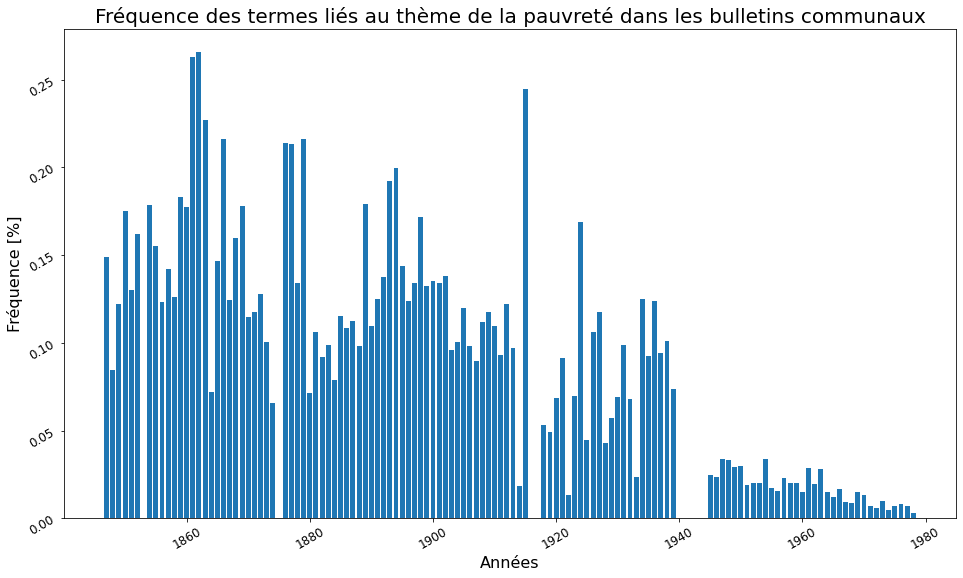

In [8]:
fig = plt.figure(figsize=(16,9))
plt.bar(yearly_freq.index, yearly_freq.values)
plt.xlabel('Années', fontsize=16)
plt.ylabel('Fréquence [%]', fontsize=16)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12, rotation=30)
plt.title('Fréquence des termes liés au thème de la pauvreté dans les bulletins communaux', fontsize=20)
plt.show()
fig.savefig(os.path.join(results_path, "term_frequency.png"))

In [9]:
key_years = list(yearly_freq.sort_values(ascending=False)[:10].index)
key_years = sorted(key_years)
key_years += [1924]

# Thèmes abordés lors des années clés

### Affichage des mots les plus fréquents dans un wordcloud

In [10]:
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "mois", "janvier", "février", "mars",
       "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre",
       "décembre", "art", "article", "bourgmestre", "public", "publique","secteur", 
       "proposition", "francs", "commission", "conseil", "conseiller", "communal", "projet",
       "rue", "collège", "échevin", "état", "bruxelles", "monsieur", "madame", "mesdames",
       "messieurs", "travaux", "service", "considérant", "question", "année", "budget", 
       "dépense", "dépenses", "membres", "déjà", "quelque", "avis", "alors", "arrêté", "très",
       "intervention", "date", "toujours", "doivent", "certains", "concerne", "voudrais", 
       "conseil", "administration", "echevin", "séance", "section", "ceux", "quelque", "toute",
      "propose", "chaque", "leurs", "assez", "avant", "elles", "aucune", "ensemble", "rapport",
      "communale", "exercice", "celui", "fois", "suivant", "hôtel", "échevins", "celte"]

sw += ["point", "dernier", "ans", "quelques", "donner", "hui", "pourra", "rien", "aucun", "quatre", "heures",
      "peu", "voir", "lorsque", "cent", "chez", "cinq", "dix"]

sw = set(sw)

In [11]:
for year in key_years:
    f = "Bxl_"+str(year)+"_words.txt"
    with open(os.path.join(yearly_texts_path, f)) as input_file:
        text = input_file.read()
    words = wordpunct_tokenize(text)
    words = [w for w in words if w not in sw]
    frequencies = Counter(words)
    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(results_path, f"{year}.png"))
    Image(filename=os.path.join(results_path, f"{year}.png"))

### Mots-clés via TF-IDF

In [12]:
files = [f for f in sorted(os.listdir(texts_path))]
texts = [open(os.path.join(texts_path, f)).read() for f in files]

In [13]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = wordpunct_tokenize(text)
    return tokens

In [14]:
# Instancier le modèle TF-IDF avec ses arguments
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=sw,
    max_df= 0.9,
    min_df=0.1,
    lowercase=True)

In [15]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 2min 30s, sys: 135 ms, total: 2min 31s
Wall time: 2min 31s


In [16]:
tfidf_matrix=pd.DataFrame(data = tfidf_vectors.toarray(),
                          index = files,
                          columns = vectorizer.get_feature_names_out())

### Extraction d'entités nommées

In [17]:
# On a remarqué que le mot "hospice" était également pertinent pour l'étude de la pauvreté,
# on l'ajoute donc aux keywords
keywords += ["hospices", "hospice"]

In [18]:
yearly_sentences = {}
for year in key_years:
    text = str()
    yearly_files = [f for f in files if f.startswith('Bxl_'+str(year))]
    for file in yearly_files:
        with open(os.path.join(texts_path, file), "r") as input_file:
            text_tmp = input_file.read()
            lang, conf = langid.classify(text_tmp)
            if lang == "fr":
                text += text_tmp
                text += "\n"
    yearly_sentences[year] = sent_tokenize(text)

In [19]:
for year, sents in yearly_sentences.items():
    i=0
    index = []
    for sent in sents:
        for keyword in keywords:
            if keyword in sent:
                index.append(i)
        i+=1
    index = set(index)
    yearly_sentences[year] = [sents[i] for i in index]

In [20]:
for year, sents in yearly_sentences.items():
    text = "\n".join(sents)
    with open(os.path.join(yearly_texts_path, "Bxl_%s_sents.txt" %year), "w") as output_file:
        output_file.write(text)

In [21]:
named_entities = {year: [] for year in key_years}
for year, sents in yearly_sentences.items():
    for sent in sents:
        doc = nlp(sent)
        for ent in doc.ents:
            if (ent.label_ != "MISC"
            and len(ent.text)>3
            and ent.text.lower() not in sw
            and ent.text.count(" ") < (len(ent.text)-1)/2):
                named_entities[year].append(f"{ent.text} ({ent.label_})")   
for year, entities in named_entities.items():
    named_entities[year] = set(entities)

# Création d'un modèle Word2Vec

In [22]:
# Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

### On rassemble toutes les phrases des années 1860-1925 en un seul fichier sents.txt

In [23]:
text=str()
for year in range(1860, 1925):
    yearly_files = [f for f in files if f.startswith('Bxl_'+str(year))]
    for file in yearly_files:
        with open(os.path.join(texts_path, file), "r") as input_file:
            text += input_file.read()        
            text += "\n"    

with open("data/sents.txt", "w") as outfile:
    outfile.write(text)

In [24]:
# On lit ces phrases grâce à la "classe" définie précédemment
infile = f"data/sents.txt"
sentences = MySentences(infile)

In [25]:
# %%time
# bigram_phrases = Phrases(sentences)
# bigram_phraser = Phraser(phrases_model=bigram_phrases)
# trigram_phrases = Phrases(bigram_phraser[sentences])
# trigram_phraser = Phraser(phrases_model=trigram_phrases)

# corpus = list(trigram_phraser[bigram_phraser[sentences]])

# model = Word2Vec(
#     corpus, # On passe le corpus de ngrams que nous venons de créer
#     vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
#     window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
#     min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
#     workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
#     epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
# )
# outfile = f"data/word2vec.model"
# model.save(outfile)

In [26]:
model = Word2Vec.load("data/word2vec.model")

In [27]:
model.wv.most_similar("pauvre", topn=5)

[('riche', 0.911007285118103),
 ('jeune', 0.793242335319519),
 ('consommateur', 0.780964195728302),
 ('sang', 0.7694865465164185),
 ('cruel', 0.7558524012565613)]